In [2]:
import numpy as np
import pandas as pd
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [26]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

Other indicators of cardiogenic shock: 
+ MVO2 < 60 (mixed venous oxygen saturation), obtained from the PA catheter
+ CVO2 < 60 (central venous oxygen saturation), obtained from the PA catheter or the central venous catheter
+ Caradiac index (CI) < 2.2, obtained from the PA catheter
+ Cardiac catheterization within 25 hours of ICU admission
+ Mechanical support in place: intraaortic balloon pump, impella, LVAD
+ Being on inotropes (milrinone, dobutamine)

# MVO2/CVO2

        Line 4: RA %O2 Saturation (PA Line) is CVO2
        Line 5 should be in the 90s
        Line 6: PA %O2 Saturation (PA Line) is MVO2
        Line 10: CVO2
        Line 14: CVO2

In [15]:
query = \
"""
SELECT * FROM d_items
WHERE label ~* '.*mvo2.*' OR
label ~* '.*cvo2.*' OR
label ~* '.*saturation.*'
"""
res = pd.read_sql_query(query, con)
res

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,146,143,CvO2,None,carevue,chartevents,None,None,None,None
1,3450,2265,MVO2,None,carevue,chartevents,None,None,None,None
2,3649,2574,MVO2 SAT,None,carevue,chartevents,None,None,None,None
3,4449,6947,mvo2,None,carevue,chartevents,None,None,None,None
4,14638,226860,RA %O2 Saturation (PA Line),RA %O2 Saturation (PA Line),metavision,chartevents,PA Line Insertion,%,Numeric,None
5,14639,226861,ART %O2 saturation (PA Line),ART %O2 saturation (PA Line),metavision,chartevents,PA Line Insertion,%,Numeric,None
6,14640,226862,PA %O2 Saturation (PA Line),PA %O2 Saturation (PA Line),metavision,chartevents,PA Line Insertion,%,Numeric,None
7,14641,226863,PVR %O2 Saturation (PA Line),PVR %O2 Saturation (PA Line),metavision,chartevents,PA Line Insertion,dynes*sec/cm5,Numeric,None
8,14642,226865,SVR %O2 Saturation (PA Line),SVR %O2 Saturation (PA Line),metavision,chartevents,PA Line Insertion,dynes*sec/cm5,Numeric,None
9,14787,227542,ScvO2 (Presep) Calibrated,ScvO2 (Presep) Calibrated,metavision,datetimeevents,Hemodynamics,None,Date time,None


# CVO2

In [47]:
query = \
"""
SELECT * FROM d_items 
WHERE itemid IN ('143', '226860', '227549', '226541');
"""
res = pd.read_sql_query(query, con)
res.head()

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,146,143,CvO2,None,carevue,chartevents,None,None,None,None
1,14408,226541,ScvO2 Central Venous O2% Sat,ScvO2 Central Venous O2% Sat,metavision,chartevents,Labs,None,Numeric,None
2,14638,226860,RA %O2 Saturation (PA Line),RA %O2 Saturation (PA Line),metavision,chartevents,PA Line Insertion,%,Numeric,None
3,14791,227549,ScvO2 (Presep),ScvO2 (Presep),metavision,chartevents,Hemodynamics,%,Numeric,None


In [50]:
query = \
"""
SELECT * FROM chartevents ce 
WHERE ce.itemid IN ('143', '226860', '227549', '226541');
"""
res = pd.read_sql_query(query, con)
res.head()

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,34305235,3,145834,211552,143,2101-10-21 23:38:00,2101-10-22 00:05:00,21570,7.2721400260925293,7.27214,ml/dl,NaN,NaN,None,NotStopd
1,34356168,25,129635,203487,143,2160-11-02 12:57:00,2160-11-02 13:21:00,15218,9.9763402938842773,9.97634,ml/dl,NaN,NaN,None,NotStopd
2,35310097,199,185360,290804,143,2167-07-16 09:11:00,2167-07-16 09:31:00,15331,11.173800468444824,11.17380,ml/dl,NaN,NaN,None,NotStopd
3,35980335,356,135591,289482,143,2132-08-06 17:11:00,2132-08-06 19:09:00,21570,9.3586997985839844,9.35870,ml/dl,NaN,NaN,None,NotStopd
4,36946150,507,136251,264188,143,2148-10-04 18:44:00,2148-10-04 19:13:00,19963,9.6417598724365234,9.64176,ml/dl,NaN,NaN,None,NotStopd


In [44]:
res['itemid'].value_counts()

227549    1970
143        264
226541      16
Name: itemid, dtype: int64

In [46]:
res.groupby('itemid')['valuenum'].describe().unstack()

,count,mean,std,min,25%,50%,75%,max
itemid,,,,,,,,
143,261.0,10.310947,2.204420,3.1141,8.73232,10.1621,11.9317,19.016001
226541,16.0,52.312500,11.067784,31.0000,45.50000,55.0000,58.2500,69.000000
227549,1970.0,74.997462,11.175660,15.0000,71.00000,78.0000,82.0000,97.000000


Convert 143 back to percentage saturation, depends on the h

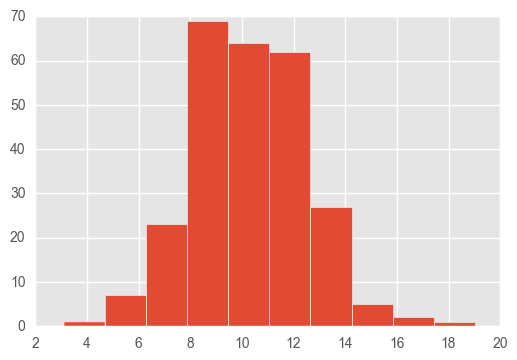

In [53]:
res.loc[res['itemid'] == 143, 'valuenum'].hist()

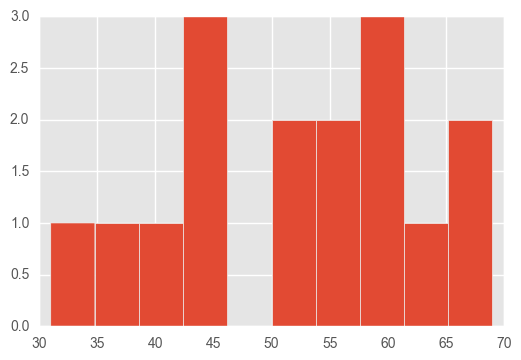

In [54]:
res.loc[res['itemid'] == 226541, 'valuenum'].hist()

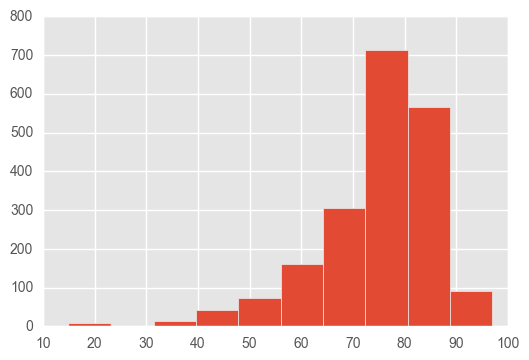

In [55]:
res.loc[res['itemid'] == 227549, 'valuenum'].hist()

# MVO2

In [59]:
query = \
"""
SELECT * FROM d_items 
WHERE itemid IN ('2265', '2574', '6947', '226862');
"""
res = pd.read_sql_query(query, con)
res.head()

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,3450,2265,MVO2,None,carevue,chartevents,None,None,None,None
1,3649,2574,MVO2 SAT,None,carevue,chartevents,None,None,None,None
2,4449,6947,mvo2,None,carevue,chartevents,None,None,None,None
3,14640,226862,PA %O2 Saturation (PA Line),PA %O2 Saturation (PA Line),metavision,chartevents,PA Line Insertion,%,Numeric,None


In [60]:
query = \
"""
SELECT * FROM chartevents
WHERE itemid IN ('2265', '2574', '6947', '226862');
"""
res = pd.read_sql_query(query, con)
res.head()

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,84265077,9699,146513,262662,2574,2188-06-16 02:00:00,2188-06-16 02:36:00,20971,58,58.0,None,None,None,None,None
1,84266075,9699,146513,262662,2574,2188-06-16 23:00:00,2188-06-16 23:24:00,20971,65,65.0,None,None,None,None,None
2,84265275,9699,146513,262662,2574,2188-06-16 06:00:00,2188-06-16 06:00:00,20971,66,66.0,None,None,None,None,None
3,84264784,9699,146513,262662,2574,2188-06-15 20:00:00,2188-06-16 02:36:00,20971,51,51.0,None,None,None,None,None
4,84265817,9699,146513,262662,2574,2188-06-16 17:00:00,2188-06-16 17:57:00,21095,70,70.0,None,None,None,None,None


In [61]:
res['itemid'].value_counts()

2265    73
2574     7
6947     3
Name: itemid, dtype: int64

In [62]:
res.groupby('itemid')['valuenum'].describe().unstack()

,count,mean,std,min,25%,50%,75%,max
itemid,,,,,,,,
2265,72.0,69.500000,6.009382,61.0,65.0,68.0,73.0,85.0
2574,7.0,59.857143,8.668498,46.0,54.5,63.0,65.5,70.0
6947,3.0,67.333333,2.309401,66.0,66.0,66.0,68.0,70.0


# Cardiac Index

In [17]:
query = \
"""
SELECT * FROM d_items
WHERE label ~* '.*cardiac index.*'
"""
res = pd.read_sql_query(query, con)
res

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,121,116,Cardiac Index,None,carevue,chartevents,None,None,None,None
1,4721,7610,cardiac index o,None,carevue,chartevents,None,None,None,None
2,15497,228368,Cardiac Index (CI NICOM),Cardiac Index (CI NICOM),metavision,chartevents,NICOM,L/min/m2,Numeric,None


This one was really easy to find. Again, use most proximal to echo? 

In [63]:
query = \
"""
SELECT * FROM chartevents
WHERE itemid IN ('116', '7610', '228368');
"""
res = pd.read_sql_query(query, con)
res.head()

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,34335423,13,143045,263738.0,116,2167-01-11 05:00:00,2167-01-11 05:19:00,20971,2.6853899955749512,2.68539,...,NaN,NaN,None,NotStopd
1,34360417,28,162569,225559.0,116,2177-09-01 23:35:00,2177-09-01 23:33:00,17130,2.6681599617004395,2.66816,...,NaN,NaN,None,NotStopd
2,34342059,20,157681,264490.0,116,2183-04-29 02:15:00,2183-04-29 02:11:00,17461,2.1924901008605957,2.19249,...,NaN,NaN,None,NotStopd
3,34305302,3,145834,211552.0,116,2101-10-22 01:00:00,2101-10-22 02:46:00,21570,4.0991001129150391,4.09910,...,NaN,NaN,None,NotStopd
4,34356286,25,129635,203487.0,116,2160-11-02 17:00:00,2160-11-02 17:20:00,15331,3.7991299629211426,3.79913,...,NaN,NaN,None,NotStopd


In [64]:
res.groupby('itemid')['valuenum'].describe().unstack()

,count,mean,std,min,25%,50%,75%,max
itemid,,,,,,,,
116,208629.0,2.947742,0.990726,0.0,2.30041,2.73885,3.33333,20.053499
7610,1.0,2.900000,NaN,2.9,2.90000,2.90000,2.90000,2.900000
228368,880.0,2.942091,1.403736,1.0,2.20000,2.70000,3.40000,31.000000


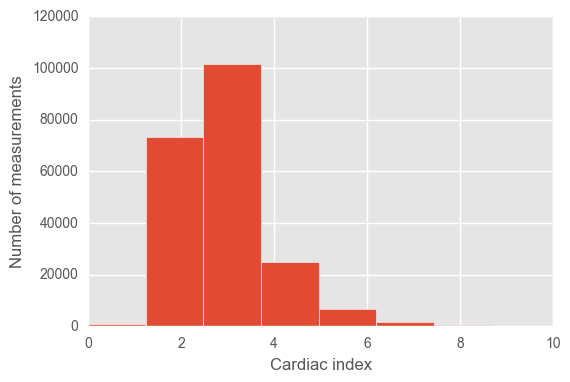

In [65]:
res['valuenum'].astype(float).hist(bins = 25)
plt.xlim([0, 10])
plt.xlabel('Cardiac index')
plt.ylabel('Number of measurements')

# Procedures

Just cardiac cath is correct. Also, look in procedures. 

In [42]:
query = \
"""
SELECT * FROM d_items
WHERE label ~* '.*cardiac cath.*' OR
label ~* '.*percutaneous coronary intervention.*' OR
label ~* '.*pci.*' OR
label ~* '.*coronary arteriography.*' OR
label ~* '.*coronary angiogram.*' OR 
label ~* '.*coronary.*'
"""
res = pd.read_sql_query(query, con)
res

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,6193,41627,pepcid gtt,None,carevue,inputevents_cv,Free Form Intake,None,None,None
1,13897,225430,Cardiac Cath,Cardiac Cath,metavision,procedureevents_mv,4-Procedures,None,Process,None
2,14060,225907,Famotidine (Pepcid),Famotidine (Pepcid),metavision,inputevents_mv,Medications,dose,Solution,None


In [35]:
query = \
"""
SELECT * FROM procedureevents_mv WHERE itemid = '225430'; 
"""
res = pd.read_sql_query(query, con)
res.shape

(473, 25)

Also look in icd_procedures:

In [41]:
query = \
"""
SELECT * FROM d_icd_procedures 
WHERE long_title ~* '.*cardiac cath.*' OR 
long_title ~* '.*percutaneous coronary intervention.*' OR
long_title ~* '.*pci.*' OR
long_title ~* '.*coronary arteriography.*' OR
long_title ~* '.*coronary angiogram.*' OR 
long_title ~* '.*coronary.*'
"""
res = pd.read_sql_query(query, con)
res

,row_id,icd9_code,short_title,long_title
0,88,0066,PTCA,Percutaneous transluminal coronary angioplasty...
1,154,0024,IVUS coronary vessels,Intravascular imaging of coronary vessels
2,176,0052,Imp/rep lead lf ven sys,Implantation or replacement of transvenous lea...
3,183,0059,Intravasc msmnt cor art,Intravascular pressure measurement of coronary...
4,607,3691,Coron vess aneurysm rep,Repair of aneurysm of coronary vessel
5,614,3721,Rt heart cardiac cath,Right heart cardiac catheterization
6,655,3603,Open coronry angioplasty,Open chest coronary artery angioplasty
7,656,3604,Intrcoronry thromb infus,Intracoronary artery thrombolytic infusion
8,657,3606,Ins nondrug elut cor st,Insertion of non-drug-eluting coronary artery ...
9,658,3607,Ins drug-elut coronry st,Insertion of drug-eluting coronary artery sten...


Joins on `procedures_icd`, which only has `hadm_id`. 

# IABP/Impella etc.

All except 4. 

In [15]:
query = \
"""
SELECT * FROM d_items
WHERE 
label ~* '.*intraaortic.*' OR
label ~* '.*iabp.*' OR
label ~* '.*impella.*' OR
label ~* '.*lvad .*'
"""
res = pd.read_sql_query(query, con)


In [25]:
for _, row in res.iterrows():
    print(',{:<8}-- {:<40}| {}'.format(row['itemid'], row['label'], row['dbsource']))

,224     -- IABP Mean                               | carevue
,225     -- IABP setting                            | carevue
,429     -- LVAD Flow LPM                           | carevue
,5938    -- lvad svr                                | carevue
,2515    -- IABP-BP                                 | carevue
,2865    -- iabp-bp                                 | carevue
,6424    -- IABP BP                                 | carevue
,228148  -- ABI Ankle BP R (Impella)                | metavision
,228149  -- ABI Brachial BP L (Impella)             | metavision
,228154  -- Impella 2.5 Flow Rate                   | metavision
,228160  -- Impella Aortic Pressure Tubing Change   | metavision
,228162  -- Impella Catheter Position               | metavision
,228163  -- Impella Catheter Repositioned           | metavision
,228164  -- Impella Catheter Site                   | metavision
,228165  -- Impella Daily Tubing Change             | metavision
,228166  -- Impella Dressing Change           